# Autoencoder를 사용한 시계열 이상 탐지

## 이상 탐지 (Anomaly Detection)

- 엘리베이터, 에스컬레이터 같은 설비 시설의 고장을 사전에 막는 것 중요  


- __이상 탐지__ 는 데이터를 통해 이상 패턴(이상징후), 개체 등을 찾아내는 것을 의미  


-  이상 패턴을 즉각적으로 찾아서 고장을 사전에 방지할 수 있음

![image](https://user-images.githubusercontent.com/84179578/130635006-2b5f4ac6-5ead-44b8-bf4d-79003c629721.png)


----
## 머신러닝, 딥러닝을 활용한 이상 탐지
- 지도 학습
  - 정상 데이터 + 이상 데이터로 학습
  - 충분한 양의 (ex.엘리베이터)의 이상 데이터를 구하기 어려움
  - 새로운 이상 패턴이 발생할 때 마다  새로 학습을 진행해야함
  

- 비지도 학습
  - Autoencoder


## Autoencoder

오토인코더는 입력된 데이터를 재구성(복원)해내는 기능을 가진 알고리즘이다.  

즉, 입력 데이터인 정상 데이터에 대한 특징을 학습하고 학습된 모델에 데이터를 집어 넣었을 때 재구성한 결과와 학습된 정상 특징과의 차이점을 비교해 이상 여부를 판단하게 된다.

![image](https://user-images.githubusercontent.com/84179578/130632919-bdbe4872-00a5-4f5c-98ef-becc90bd5a6b.png)

![image](https://user-images.githubusercontent.com/84179578/130633424-00e9804c-0359-4b11-b6c0-15a70060278a.png)

## 0. 필요한 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## 1. 데이터 불러오기

캐글에서 제공하는 [Numenta Anomaly Benchmark(NAB)](https://www.kaggle.com/boltzmannbrain/nab) 를 사용한다.  

- `art_daily_small_noise.csv` : 정상적인 데이터 -> 훈련 데이터로 사용

- `art_daily_jumpsup.csv` : 이상치가 포함되어 있는 데이터 -> 테스트 데이터로 사용

In [2]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [3]:
df_small_noise

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120
...,...
2014-04-14 23:35:00,20.211195
2014-04-14 23:40:00,20.531041
2014-04-14 23:45:00,19.032127


In [4]:
df_daily_jumpsup

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739
...,...
2014-04-14 23:35:00,18.074649
2014-04-14 23:40:00,21.002014
2014-04-14 23:45:00,20.566713


----
## 2. 데이터 시각화

### 정상 데이터

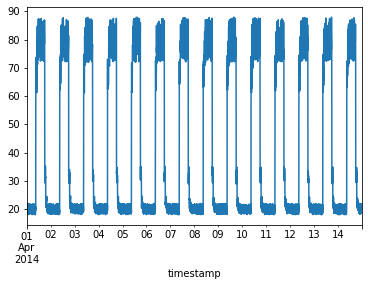

In [5]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

### 이상 데이터

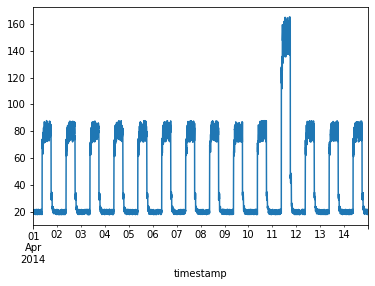

In [6]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

----
## 3. 훈련 데이터 준비

### 정규화 (Normalization)

Z-Score Normailization   ->  $(X - 평균) / 표준편차$

In [7]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


In [8]:
print(df_training_value.shape)

(4032, 1)


- 24 * 60 / 5 = __하루에 288개의 시간 단계__
- 288 * 14 = __총 4032개의 데이터 포인트__

### 시퀀스 생성
`TIME_STEPS`훈련 데이터에서 연속 데이터 값을 결합하는 시퀀스를 생성

In [9]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


----
## 4. 모델 생성
Convolutional reconstruction autoencoder model 을 구축한다.

모델의 입력은 (`batch_size`, `sequence_length`, `num_features`) 를 받고 동일한 shape의 출력을 반환한다.  

지금의 경우,  `sequence_length`은 288, `num_features`은 1 이다.

In [10]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

----
## 5. 모델 훈련
Reconstruction Model을 구축하는 것이므로 input 데이터와 target 데이터 모두 `x_train` 을 넣어준다.

In [11]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 10s 194ms/step - loss: 0.7471 - val_loss: 0.0790
Epoch 2/50
27/27 [==============================] - 0s 11ms/step - loss: 0.0829 - val_loss: 0.0395
Epoch 3/50
27/27 [==============================] - 0s 10ms/step - loss: 0.0552 - val_loss: 0.0313
Epoch 4/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0460 - val_loss: 0.0267
Epoch 5/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0392 - val_loss: 0.0234
Epoch 6/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0346 - val_loss: 0.0217
Epoch 7/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0314 - val_loss: 0.0198
Epoch 8/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0289 - val_loss: 0.0185
Epoch 9/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0267 - val_loss: 0.0176
Epoch 10/50
27/27 [==============================] - 0s 9ms/step - loss: 0.0251 - val_loss: 0.0159
Epoch 11/50
27

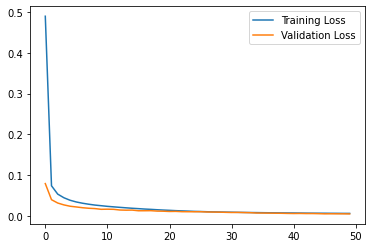

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

----
## 6. 이상 탐지

모델이 입력 데이터를 얼마나 잘 재구성 할 수 있는지 결정하여 이상을 탐지한다. 과정은 아래와 같다.  

- 1. 훈련 샘플에서 MAE (평균절대오차) loss를 구함
- 2. 훈련 샘플에서의 최대 MAE loss 값을 찾아서 threshold(한계점)으로 지정
- 3. 샘플의 reconstruction loss 가 threshold 값 보다 크면 이상(anomaly) 패턴으로 추론

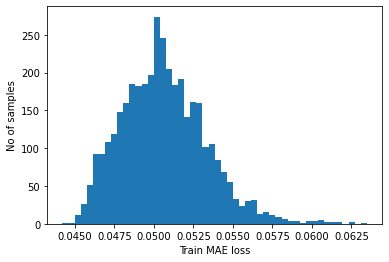

Reconstruction error threshold:  0.06347774017428494


In [13]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Recontruction 비교

모델이 `x_train` 데이터를 어떻게 재구성했는지 확인해보자. 

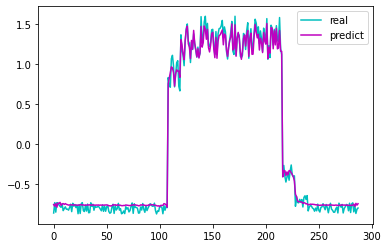

In [14]:
# Checking how the first sequence is learnt
plt.plot(x_train[0], color='c', label='real')
plt.legend()
plt.plot(x_train_pred[0],color='m', label='predict')
plt.legend()
plt.show()

### 테스트 데이터 준비

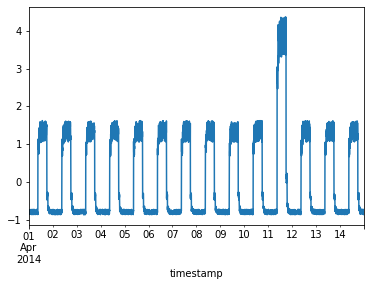

In [15]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

In [16]:
# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


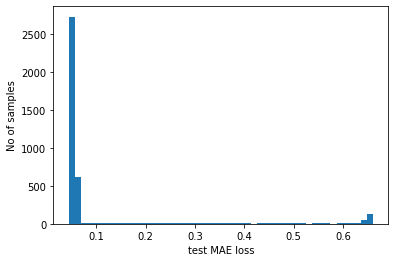

In [17]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [18]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  416
Indices of anomaly samples:  (array([ 775,  791,  792,  793,  794,  795,  797,  973, 1657, 1945, 2520,
       2521, 2522, 2523, 2698, 2701, 2702, 2703, 2704, 2705, 2706, 2707,
       2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718,
       2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729,
       2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740,
       2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751,
       2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762,
       2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773,
       2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784,
       2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795,
       2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806,
       2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817,
       2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2

----
## 7. 이상치 시각화

위에서 구한 비정상 데이터 샘플을 이용하여 `timestamps` 원본 테스트 데이터에서 해당 항목을 찾을 수 있다.

예를 들어, time_steps = 3 이고, 10개의 훈련 값이 있다고 가정  
- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

샘플 \[(3, 4, 5), (4, 5, 6), (5, 6, 7)\]이 비정상이라는 것을 안다면, 데이터 포인트 5가 비정상이라고 말할 수 있다.    



즉, (i - `timesteps` + 1)번째 샘플데이터부터 i번째 샘플데이터가 비정상 데이터라면 i번째 데이터가 비정상 데이터라고 할 수 있다.  

이때, 처음 `time_step`-1 번째까지의 샘플데이터와  마지막에서 `time_step`-1 번째까지의 샘플 데이터는 제외

In [19]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

원본 테스트 데이터에 이상 데이터를 시각화 해보겠다.

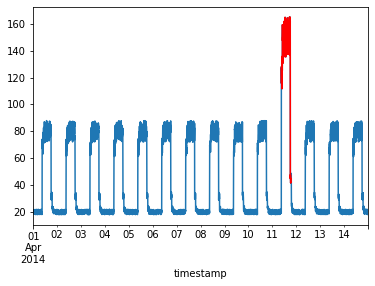

In [20]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

----
----
# LSTM Autoencoder 을 사용한 시계열 데이터 이상 탐지

## 모델 생성

In [21]:
model = keras.Sequential()
model.add(layers.LSTM(
    units=64,
    input_shape=(x_train.shape[1], x_train.shape[2])
))
model.add(layers.Dropout(rate=0.2))
model.add(layers.RepeatVector(n=x_train.shape[1]))
model.add(layers.LSTM(units=64, return_sequences=True))
model.add(layers.Dropout(rate=0.2))
model.add(
    
    layers.TimeDistributed(
    layers.Dense(units=x_train.shape[2])
  )
)
model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 288, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 288, 64)           33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 288, 64)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 288, 1)            65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
__________________________________________________

## 모델 훈련

In [22]:
history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 5s 106ms/step - loss: 1.0005 - val_loss: 0.9824
Epoch 2/50
27/27 [==============================] - 2s 80ms/step - loss: 0.9550 - val_loss: 0.9247
Epoch 3/50
27/27 [==============================] - 2s 80ms/step - loss: 0.9242 - val_loss: 0.9290
Epoch 4/50
27/27 [==============================] - 2s 80ms/step - loss: 0.9193 - val_loss: 0.9169
Epoch 5/50
27/27 [==============================] - 2s 80ms/step - loss: 0.8847 - val_loss: 1.0703
Epoch 6/50
27/27 [==============================] - 2s 80ms/step - loss: 0.9366 - val_loss: 0.8619
Epoch 7/50
27/27 [==============================] - 2s 80ms/step - loss: 0.8025 - val_loss: 0.7721
Epoch 8/50
27/27 [==============================] - 2s 80ms/step - loss: 0.7117 - val_loss: 0.5086
Epoch 9/50
27/27 [==============================] - 2s 80ms/step - loss: 0.4305 - val_loss: 0.2180
Epoch 10/50
27/27 [==============================] - 2s 81ms/step - loss: 0.2597 - val_loss: 0.1666
Epoch 11

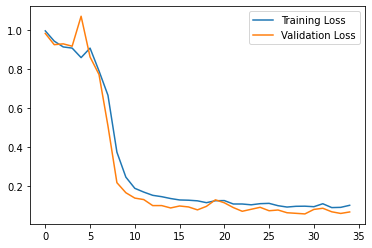

In [23]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## 이상 탐지

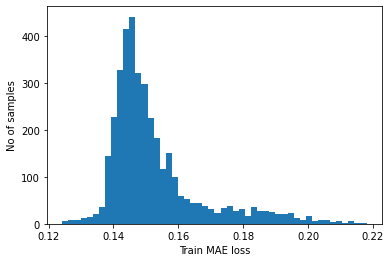

Reconstruction error threshold:  0.21807852983574072


In [24]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Recontruction 비교
모델이 `x_train` 데이터를 어떻게 재구성했는지 확인해보자.

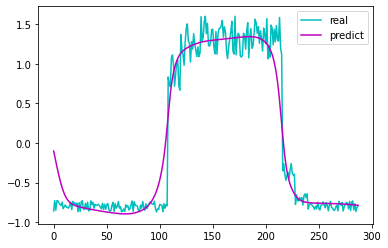

In [25]:
# Checking how the first sequence is learnt
plt.plot(x_train[0], color='c', label='real')
plt.legend()
plt.plot(x_train_pred[0],color='m', label='predict')
plt.legend()
plt.show()

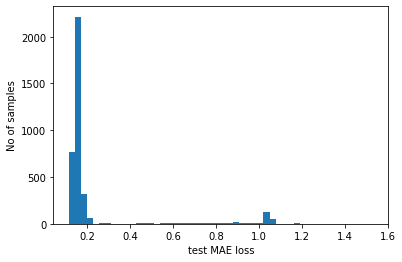

In [26]:
# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

In [27]:
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

Number of anomaly samples:  389
Indices of anomaly samples:  (array([2386, 2387, 2388, 2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710,
       2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721,
       2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732,
       2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743,
       2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754,
       2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765,
       2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776,
       2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787,
       2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798,
       2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809,
       2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820,
       2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831,
       2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2840, 2

## 이상치 시각화

In [28]:
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

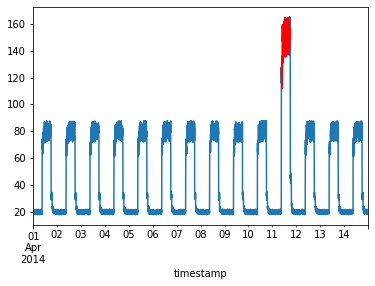

In [29]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

autoencoder 를 사용하여 이상 탐지를 할 수 있는 것을 확인 할 수 있다.